## **Estudiante:** Emanuel Acevedo Muñoz


## **El entregable debe contener.**

* Análisis de las variables (EDA) completo de las variables (1.0) Ir generando insights de las gráficas, tablas encontradas.

* Transformaciones de variables. Esto debe incluir eliminación de variables irrelevantes, imputación de nulos, revisión de variables redundantes (consultar la matriz de correlación), transformaciones que consideren necesarias para las variables categóricas, dummies, normalización, etc. (2.0)

* Explicación del modelo. Debe explicar de forma breve el modelo y sus
hiperparámetros. Comparar el árbol de decisión con respecto a k-vecinos (1.0)

* Realizar un apartado de evaluación. Encuentre las métricas de evaluación y detalle una explicación al respecto de dichas métricas respecto a los dos modelos evaluados. ¿Cuál escogerían y por qué? (1.0)


### **Nuestra variable objetivo**
Nuestro cliente desea saber las características más importantes que tienen los pacientes de
cierto tipo de enfermedad que terminan en hospitalización

In [1]:
import kagglehub

In [2]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person629_bacteria_2509.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person952_bacteria_2877.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1315_virus_2270.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1392_bacteria_3538.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person475_bacteria_2025.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1288_bacteria_3251.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1005_virus_1688.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person442_virus_900.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person755_bacteria_2659.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person655_bacteria_2547.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray

In [5]:
# Define paths
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

# Image dimensions
img_height, img_width = 224, 224
batch_size = 32


                   TRAINING SET                   
Dataset directory: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Total number of classes: 2
Classes: ['NORMAL', 'PNEUMONIA']

      Class Distribution      
------------------------------
NORMAL         : 1341 (25.7%)
PNEUMONIA      : 3875 (74.3%)


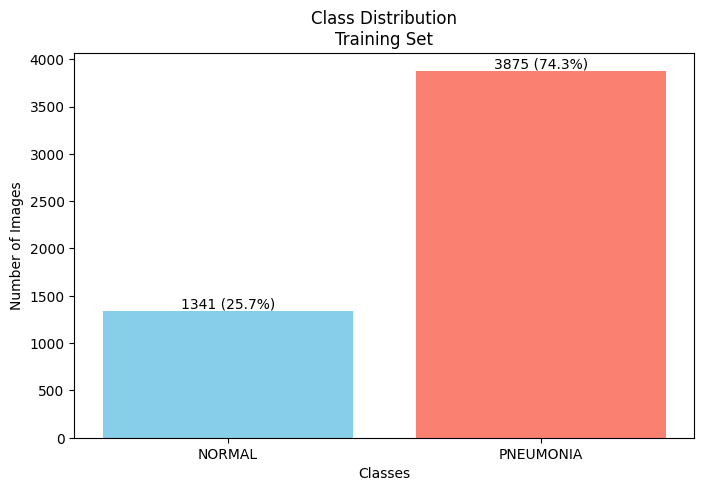


Sample images from each class:
Found 5216 images belonging to 2 classes.


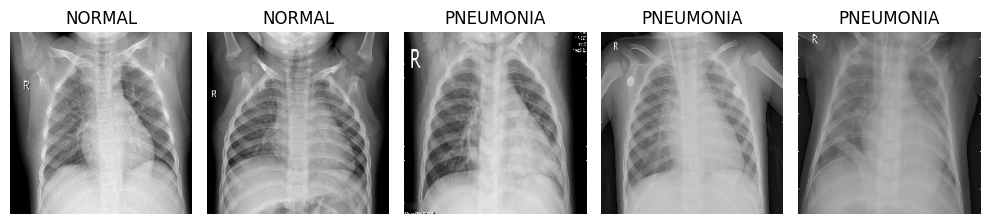


                  VALIDATION SET                  
Dataset directory: /kaggle/input/chest-xray-pneumonia/chest_xray/val
Total number of classes: 2
Classes: ['NORMAL', 'PNEUMONIA']

      Class Distribution      
------------------------------
NORMAL         :    8 (50.0%)
PNEUMONIA      :    8 (50.0%)


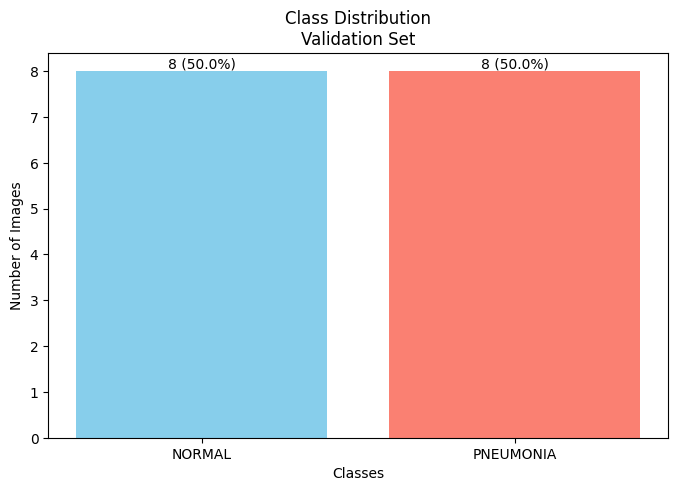


Sample images from each class:
Found 16 images belonging to 2 classes.


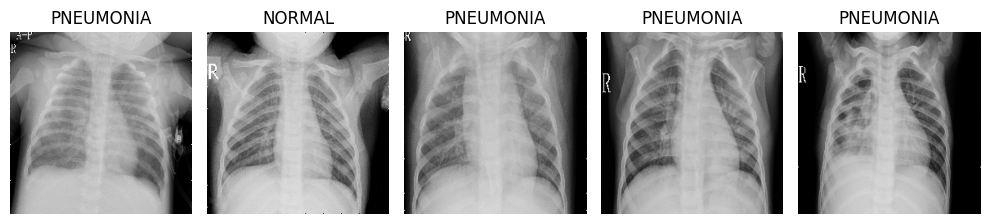


                     TEST SET                     
Dataset directory: /kaggle/input/chest-xray-pneumonia/chest_xray/test
Total number of classes: 2
Classes: ['NORMAL', 'PNEUMONIA']

      Class Distribution      
------------------------------
NORMAL         :  234 (37.5%)
PNEUMONIA      :  390 (62.5%)


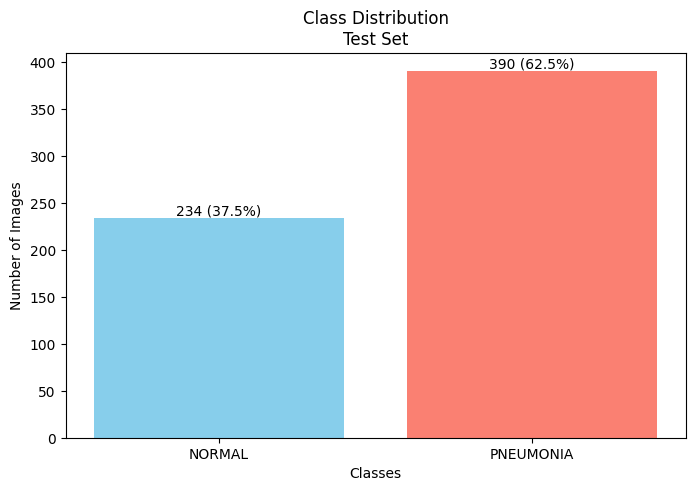


Sample images from each class:
Found 624 images belonging to 2 classes.


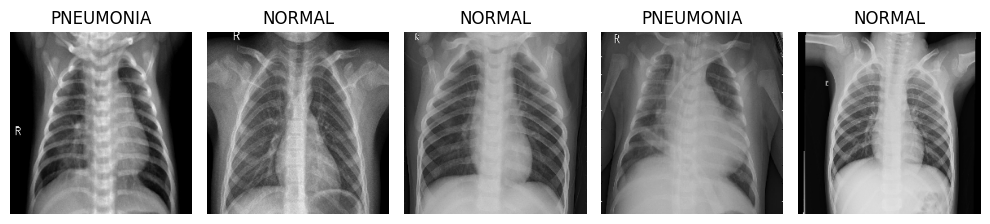

In [6]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def analyze_dataset(directory, title="Dataset Analysis"):
    """
    Analyze and display dataset information including class distribution.

    Args:
        directory (str): Path to the dataset directory
        title (str): Title for the analysis output
    """
    # Get class names from subdirectories
    classes = sorted(os.listdir(directory))

    # Count number of files in each class
    class_counts = {}
    for cls in classes:
        class_path = os.path.join(directory, cls)
        if os.path.isdir(class_path):
            class_counts[cls] = len(os.listdir(class_path))

    # Print dataset information
    print(f"\n{'='*50}")
    print(f"{title.upper():^50}")
    print(f"{'='*50}")
    print(f"Dataset directory: {directory}")
    print(f"Total number of classes: {len(class_counts)}")
    print(f"Classes: {list(class_counts.keys())}")
    print(f"\n{'Class Distribution':^30}")
    print("-"*30)

    total_samples = sum(class_counts.values())
    for cls, count in class_counts.items():
        print(f"{cls:15}: {count:4} ({count/total_samples:.1%})")

    # Plot class distribution
    plt.figure(figsize=(8, 5))
    bars = plt.bar(class_counts.keys(), class_counts.values(), color=['skyblue', 'salmon'])
    plt.title(f'Class Distribution\n{title}')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')

    # Add percentage labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height} ({height/total_samples:.1%})',
                ha='center', va='bottom')

    plt.show()

    # Print sample images
    print("\nSample images from each class:")
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=5,
        class_mode='binary',
        shuffle=True
    )

    # Display sample images
    plt.figure(figsize=(10, 5))
    images, labels = next(generator)
    class_names = list(class_counts.keys())

    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Analyze all datasets
analyze_dataset(train_dir, "Training Set")
analyze_dataset(val_dir, "Validation Set")
analyze_dataset(test_dir, "Test Set")

Explanation:
In this section, we combine and re-split the datasets with balanced class distribution:

combine_and_resplit_datasets() function:
This function combines images from the original train, validation, and test directories into a temporary directory.
It then splits the combined dataset into new training, validation, and test sets, ensuring a balanced distribution of classes.
train_test_split() from sklearn is used to split the data into training, validation, and test sets.
Finally, it saves the split datasets into new directories.

In [7]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil
import tempfile

def combine_and_resplit_datasets(original_train_dir, original_val_dir, original_test_dir,
                               new_train_dir, new_val_dir, new_test_dir,
                               test_size=0.2, val_size=0.1, random_state=42):
    """
    Combine all datasets and re-split with balanced class distribution.

    Args:
        original_train_dir: Path to original training set
        original_val_dir: Path to original validation set
        original_test_dir: Path to original test set
        new_train_dir: Path for new training set
        new_val_dir: Path for new validation set
        new_test_dir: Path for new test set
        test_size: Proportion for test split
        val_size: Proportion for validation split (of remaining after test split)
        random_state: Random seed for reproducibility
    """

    # Create temporary directory to hold all combined images
    with tempfile.TemporaryDirectory() as temp_dir:
        # Copy all images to temporary directory maintaining class structure
        for original_dir in [original_train_dir, original_val_dir, original_test_dir]:
            for class_name in ['NORMAL', 'PNEUMONIA']:
                src_dir = os.path.join(original_dir, class_name)
                dst_dir = os.path.join(temp_dir, class_name)

                os.makedirs(dst_dir, exist_ok=True)

                for img_file in os.listdir(src_dir):
                    src_path = os.path.join(src_dir, img_file)
                    dst_path = os.path.join(dst_dir, img_file)

                    # Handle potential duplicate filenames
                    if os.path.exists(dst_path):
                        base, ext = os.path.splitext(img_file)
                        dst_path = os.path.join(dst_dir, f"{base}_dup{ext}")

                    shutil.copy(src_path, dst_path)

        # Create image data generator to load all images
        datagen = ImageDataGenerator(rescale=1./255)
        generator = datagen.flow_from_directory(
            temp_dir,
            target_size=(img_height, img_width),
            batch_size=5216+16+624,  # Total number of images
            class_mode='binary',
            shuffle=False
        )

        # Get all images and labels
        images, labels = next(generator)

        # Split into train+val and test first
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            images, labels,
            test_size=test_size,
            stratify=labels,
            random_state=random_state
        )

        # Split train_val into train and val
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val,
            test_size=val_size/(1-test_size),  # Adjusted val_size
            stratify=y_train_val,
            random_state=random_state
        )

    # Create new directory structure
    for dir_path in [new_train_dir, new_val_dir, new_test_dir]:
        os.makedirs(os.path.join(dir_path, 'NORMAL'), exist_ok=True)
        os.makedirs(os.path.join(dir_path, 'PNEUMONIA'), exist_ok=True)

    # Function to save images to new directory structure
    def save_images(images, labels, target_dir):
        class_names = ['NORMAL', 'PNEUMONIA']
        for i, (image, label) in enumerate(zip(images, labels)):
            class_name = class_names[int(label)]
            img_path = os.path.join(target_dir, class_name, f"img_{i}.jpg")
            plt.imsave(img_path, image)

    # Save the new splits
    save_images(X_train, y_train, new_train_dir)
    save_images(X_val, y_val, new_val_dir)
    save_images(X_test, y_test, new_test_dir)

    print("\nDataset successfully re-split with balanced distribution!")

Found 5856 images belonging to 2 classes.

Dataset successfully re-split with balanced distribution!

                 NEW TRAINING SET                 
Dataset directory: /kaggle/working/chest_xray/train
Total number of classes: 2
Classes: ['NORMAL', 'PNEUMONIA']

      Class Distribution      
------------------------------
NORMAL         : 1108 (27.0%)
PNEUMONIA      : 2990 (73.0%)


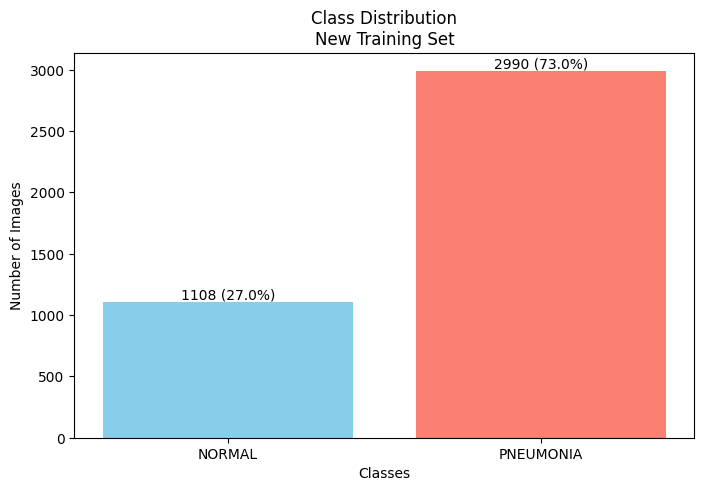


Sample images from each class:
Found 4098 images belonging to 2 classes.


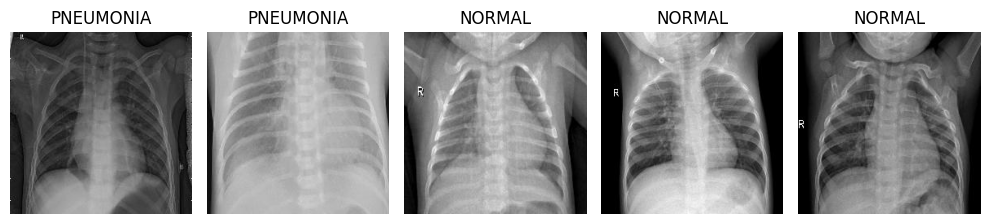


                NEW VALIDATION SET                
Dataset directory: /kaggle/working/chest_xray/val
Total number of classes: 2
Classes: ['NORMAL', 'PNEUMONIA']

      Class Distribution      
------------------------------
NORMAL         :  158 (27.0%)
PNEUMONIA      :  428 (73.0%)


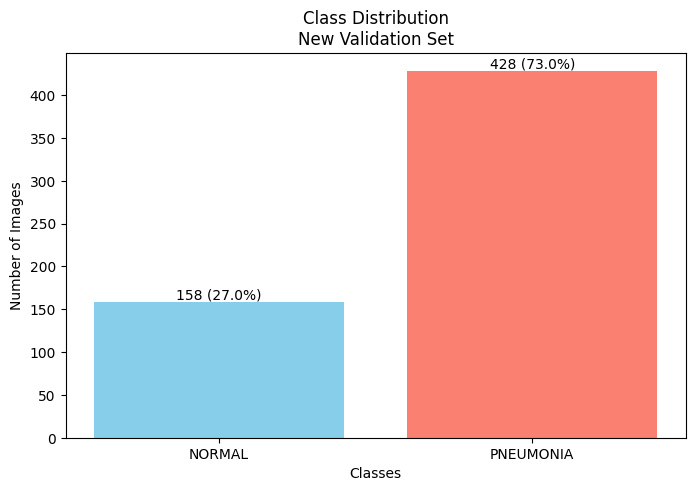


Sample images from each class:
Found 586 images belonging to 2 classes.


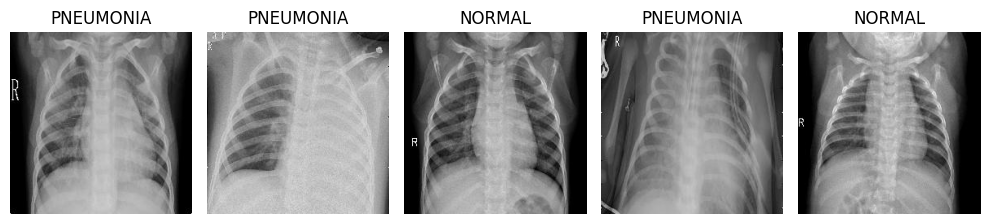


                   NEW TEST SET                   
Dataset directory: /kaggle/working/chest_xray/test
Total number of classes: 2
Classes: ['NORMAL', 'PNEUMONIA']

      Class Distribution      
------------------------------
NORMAL         :  317 (27.0%)
PNEUMONIA      :  855 (73.0%)


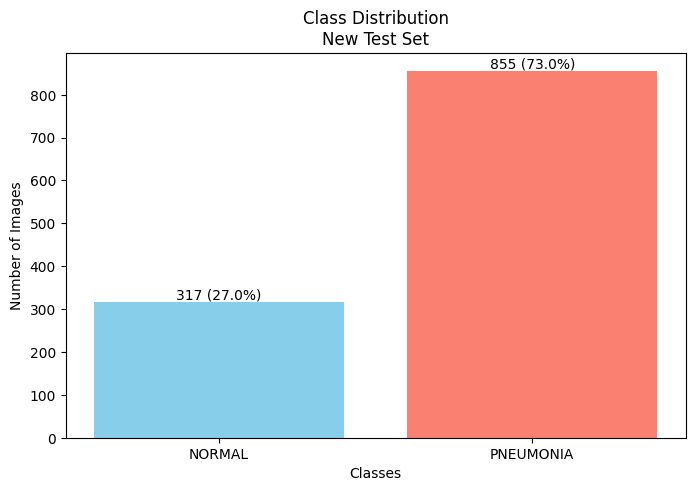


Sample images from each class:
Found 1172 images belonging to 2 classes.


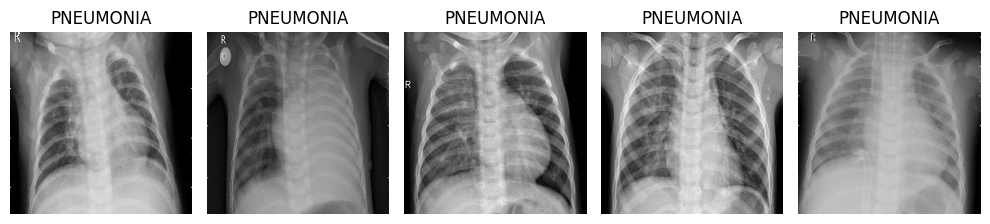

In [8]:
# Define new directory paths
new_train_dir = '/kaggle/working/chest_xray/train'
new_val_dir = '/kaggle/working/chest_xray/val'
new_test_dir = '/kaggle/working/chest_xray/test'

# Combine and re-split the dataset
combine_and_resplit_datasets(
    original_train_dir=train_dir,
    original_val_dir=val_dir,
    original_test_dir=test_dir,
    new_train_dir=new_train_dir,
    new_val_dir=new_val_dir,
    new_test_dir=new_test_dir,
    test_size=0.2,  # 20% for test
    val_size=0.1    # 10% for validation (of remaining 80%)
)

# Analyze the new datasets
analyze_dataset(new_train_dir, "New Training Set")
analyze_dataset(new_val_dir, "New Validation Set")
analyze_dataset(new_test_dir, "New Test Set")

Explanation:
This section implements the preprocessing pipeline for chest X-ray images:

preprocess_chest_xray_for_efficientnet() function:
Converts images to grayscale (if they are in RGB format).
Normalizes the image to a [0, 1] range.
Applies noise reduction techniques (Gaussian and Median filtering).
Enhances contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization).
Performs gamma correction to adjust the brightness of the image.
Converts the image to RGB format and resizes it to 224x224 pixels to match EfficientNet input requirements.
Finally, it applies EfficientNet preprocessing (efficientnet_preprocess) for further normalization.

In [9]:
def preprocess_chest_xray_for_efficientnet(image, visualize=False):
    """
    Full preprocessing pipeline for chest X-ray images:
    1. Convert to grayscale (if needed)
    2. Normalize to [0,1]
    3. Noise reduction (Gaussian + Median filtering)
    4. Contrast enhancement using CLAHE
    5. Gamma correction
    6. Convert to RGB (3 channels)
    7. EfficientNet preprocessing
    8. Optionally visualize each step
    """

    # Convert to numpy array if it's a tensor
    if tf.is_tensor(image):
        image = image.numpy()

    # Convert to grayscale if it has 3 channels
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    original_image = image.copy()  # For visualization

    # Normalize to [0,1]
    image = image.astype('float32')
    image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)

    # Scale to [0,255] for image processing
    image_uint8 = (image * 255).astype('uint8')

    # --- Noise Reduction ---
    denoised = cv2.GaussianBlur(image_uint8, (3, 3), 0)
    denoised = cv2.medianBlur(denoised, 3)

    # --- CLAHE ---
    clahe = cv2.createCLAHE(clipLimit=0.03, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(denoised)

    # --- Gamma Correction ---
    gamma = 0.7
    contrast_float = contrast_enhanced.astype('float32') / 255.0
    gamma_corrected = np.power(contrast_float, gamma)

    # Convert to 8-bit
    final_image = (gamma_corrected * 255).astype(np.uint8)

    # Convert to RGB
    final_image_rgb = np.stack((final_image,) * 3, axis=-1)

    # Resize to EfficientNet default size (224x224)
    final_image_rgb = cv2.resize(final_image_rgb, (224, 224))

    # EfficientNet preprocessing
    efficientnet_ready = efficientnet_preprocess(final_image_rgb.astype('float32'))

    # --- Visualization ---
    if visualize:
        fig, axs = plt.subplots(1, 4, figsize=(16, 4))
        axs = axs.ravel()
        steps = [original_image, denoised, contrast_enhanced, final_image]
        titles = ["Original", "Denoised", "CLAHE", "Gamma Corrected"]

        for i in range(4):
            axs[i].imshow(steps[i], cmap='gray')
            axs[i].set_title(titles[i])
            axs[i].axis('off')

        plt.tight_layout()
        plt.show()

    return efficientnet_ready

Explanation:
This section sets up data augmentation and preprocessing for the image generators:

train_datagen: An instance of ImageDataGenerator is created with various augmentations such as rotation, width/height shift, shear, zoom, and horizontal flip.
val_test_datagen: Another ImageDataGenerator is created for validation and test datasets without augmentation but with the same preprocessing pipeline applied.

In [10]:
# Update your data generators with the enhanced preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_chest_xray_for_efficientnet,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_chest_xray_for_efficientnet
)

Explanation:
This section defines the generators that will feed images into the model during training:

train_generator: Uses train_datagen for real-time data augmentation and preprocessing. It reads images from the newly created training directory, resizes them to the target size, and applies the binary class mode.
val_generator and test_generator: These generators read the images from the validation and test directories and apply the preprocessing pipeline without augmentation.

In [11]:
# Recreate your data generators with the new preprocessing
train_generator = train_datagen.flow_from_directory(
    new_train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

val_generator = val_test_datagen.flow_from_directory(
    new_val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

test_generator = val_test_datagen.flow_from_directory(
    new_test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 4098 images belonging to 2 classes.
Found 586 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


Explanation:
This section visualizes the preprocessing stages of a sample chest X-ray image:

display_preprocessing_stages(): This function takes an image, applies each preprocessing step, and then displays the intermediate results (e.g., original image, denoised image, contrast enhanced, gamma corrected, etc.) to visually verify the transformations.

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

def display_preprocessing_stages(image, figsize=(24, 10), dpi=100):
    """
    Display each stage of preprocessing for chest X-ray image with larger visualization.

    Args:
        image: Input image (can be numpy array or tensor)
        figsize: Figure size (width, height) in inches
        dpi: Dots per inch for figure resolution

    Stages displayed:
    1. Original
    2. Denoised
    3. CLAHE
    4. Gamma Corrected
    5. Final RGB
    6. EfficientNet Preprocessed
    """
    # Convert to numpy array if it's a tensor
    if tf.is_tensor(image):
        image = image.numpy()

    # Convert to grayscale if needed (and ensure 2D array)
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    elif len(image.shape) == 3 and image.shape[2] == 1:
        image = np.squeeze(image, axis=-1)

    original = image.copy()

    # Normalize to [0,1]
    image = image.astype('float32')
    image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)
    image_uint8 = (image * 255).astype('uint8')

    # Noise reduction
    denoised = cv2.GaussianBlur(image_uint8, (3, 3), 0)
    denoised = cv2.medianBlur(denoised, 3)

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=0.03, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(denoised)

    # Gamma correction
    gamma = 0.7
    contrast_float = contrast_enhanced.astype('float32') / 255.0
    gamma_corrected = np.power(contrast_float, gamma)
    gamma_corrected_uint8 = (gamma_corrected * 255).astype('uint8')

    # Final RGB
    final_rgb = np.stack((gamma_corrected_uint8,) * 3, axis=-1)

    # Resize to EfficientNet input size (224x224)
    resized = cv2.resize(final_rgb, (224, 224))

    # EfficientNet preprocessing
    efficientnet_image = efficientnet_preprocess(resized.astype('float32'))

    # For visualization, bring back EfficientNet preprocessed image to [0, 1] range
    efficientnet_vis = (efficientnet_image - efficientnet_image.min()) / (efficientnet_image.max() - efficientnet_image.min())

    # Plot all stages
    titles = ["Original", "Denoised", "CLAHE", "Gamma Corrected", "Final RGB", "EfficientNet Preprocessed"]
    images = [original, denoised, contrast_enhanced, gamma_corrected_uint8, final_rgb, efficientnet_vis]

    # Create figure with subplots
    plt.figure(figsize=figsize, dpi=dpi)

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns layout

        # Determine colormap and image data
        if i < 4:  # First four images are grayscale
            cmap = 'gray'
            display_img = img
        else:  # Last two are RGB
            cmap = None
            display_img = img

        plt.imshow(display_img, cmap=cmap)
        plt.title(title, fontsize=12, pad=10)
        plt.axis('off')

        # Add image size as text
        h, w = img.shape[:2]
        plt.text(5, 15, f"{w}x{h}", color='white' if i < 4 else 'black',
                bbox=dict(facecolor='red', alpha=0.5), fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0.2)
    plt.show()

Explanation:
This section defines the function display_images_from_generator() to display a batch of images from the generator:

It fetches a batch of images from the generator and displays them in a grid layout.
The labels for each image are shown as titles above the respective image.

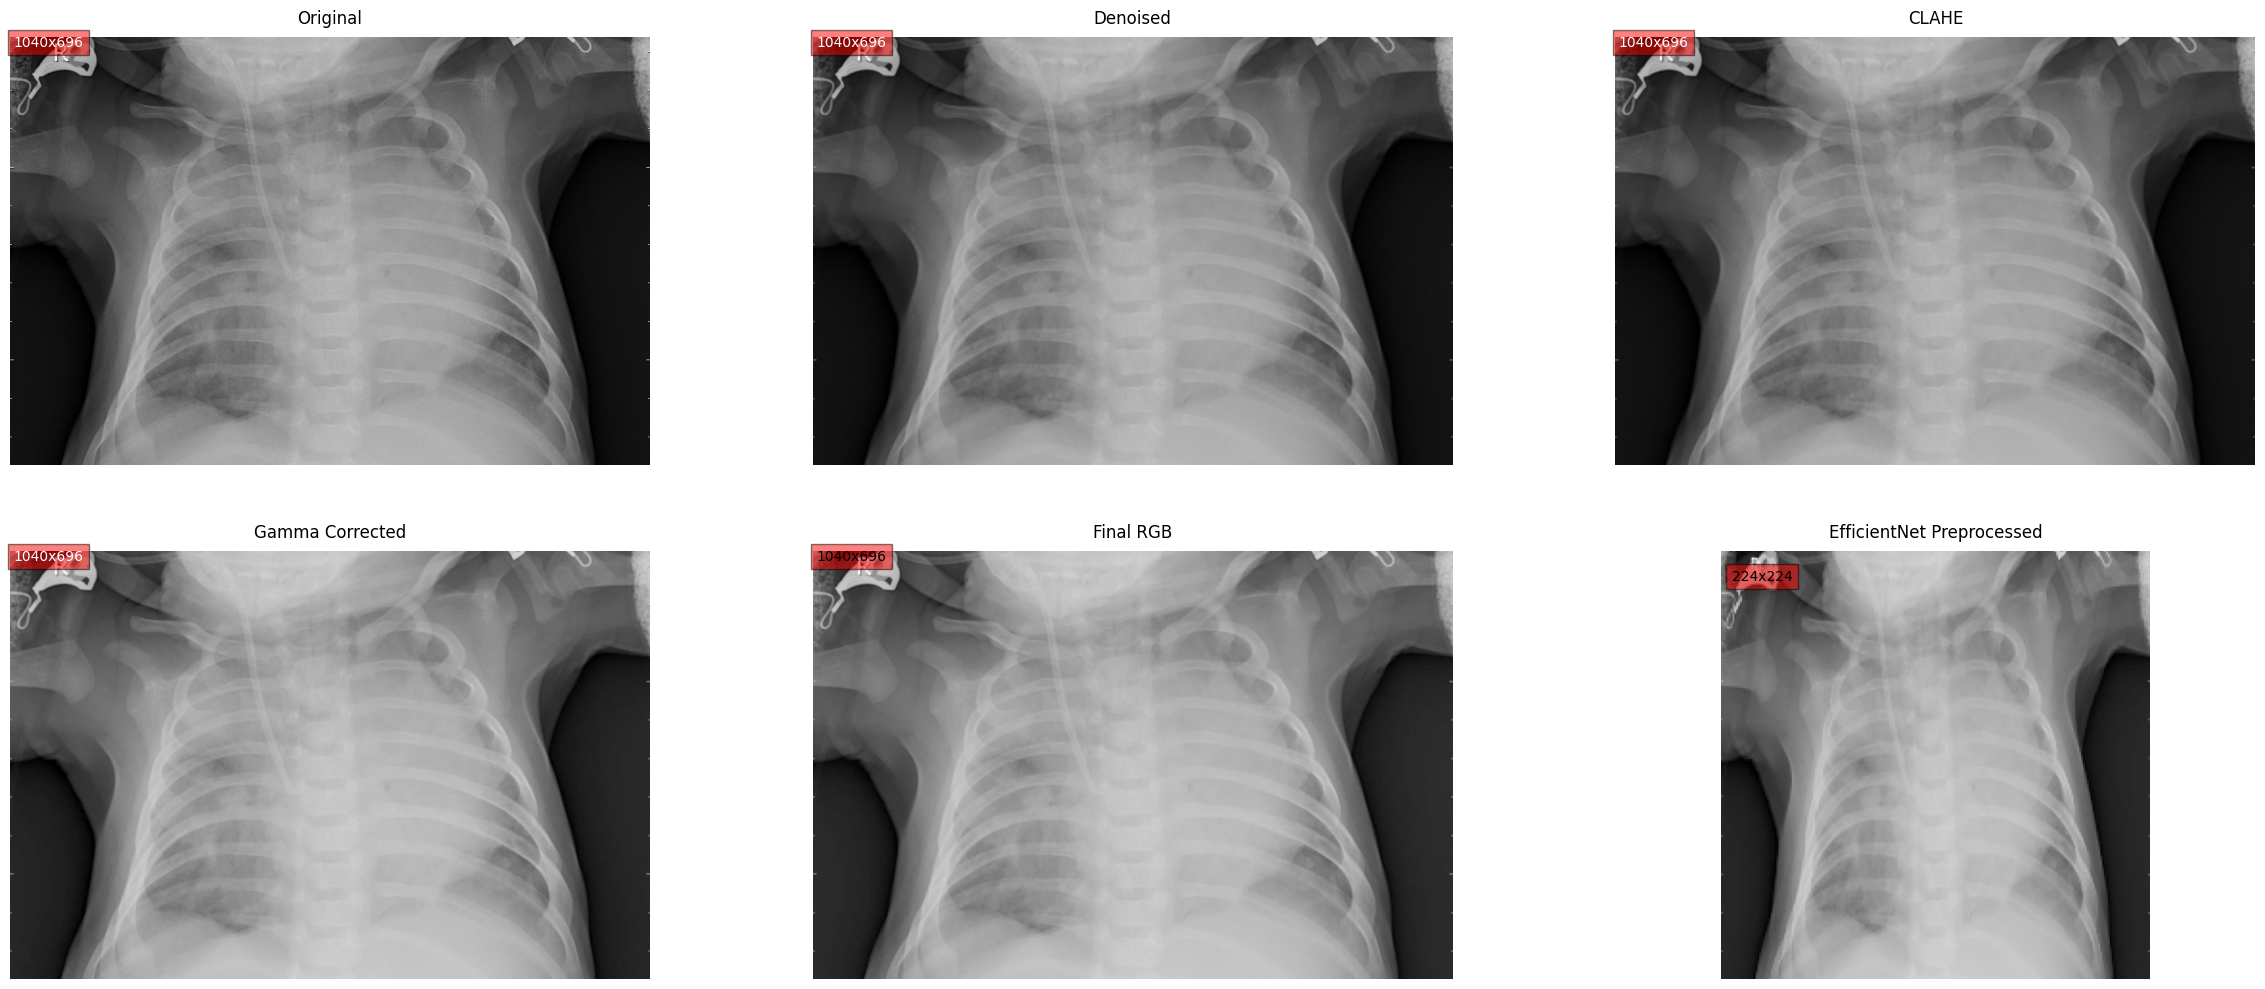

In [13]:
# Load your image
image = cv2.imread('/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg')

display_preprocessing_stages(image)

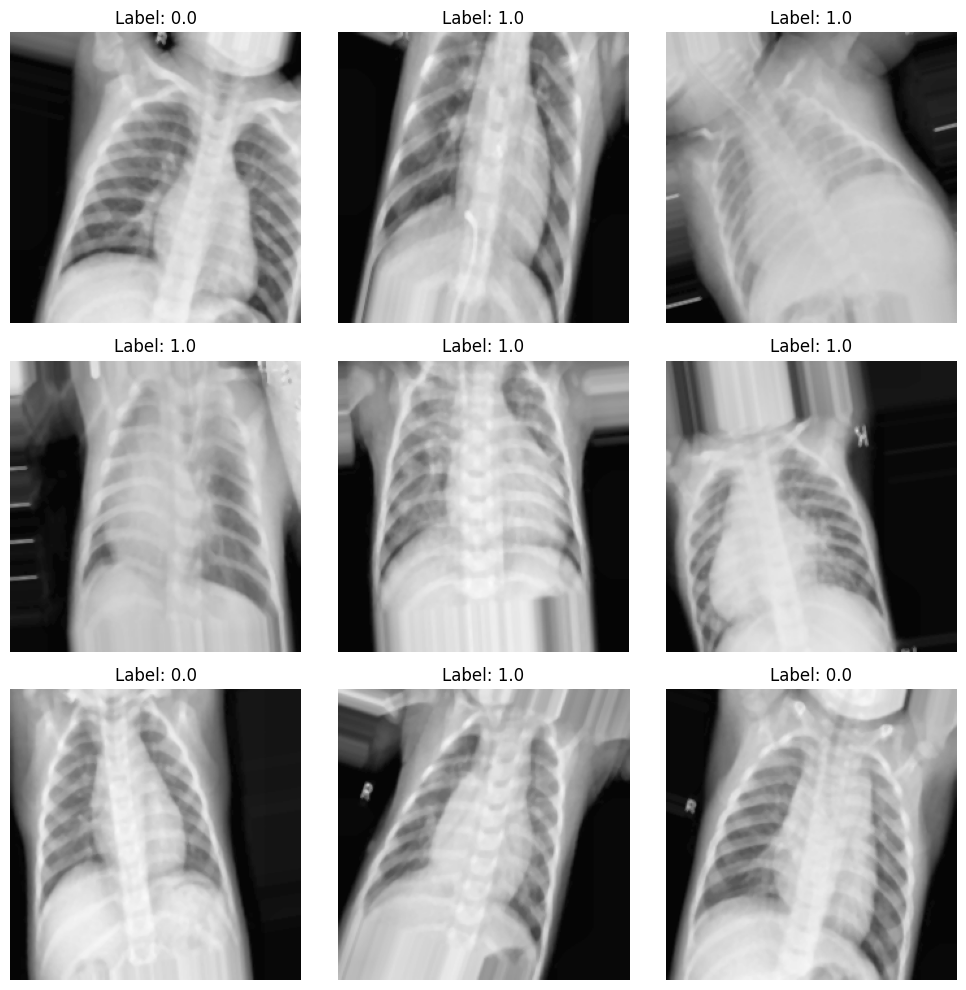

In [14]:
import matplotlib.pyplot as plt

def display_images_from_generator(generator, num_images=9):
    """
    Displays a batch of images from the generator.

    Args:
        generator: The ImageDataGenerator from which to fetch the images.
        num_images (int): Number of images to display. Default is 9.
    """
    # Get a batch of images and labels from the generator
    images, labels = next(generator)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = int(np.ceil(np.sqrt(num_images)))
    num_cols = int(np.ceil(num_images / num_rows))

    # Create a figure to display the images
    plt.figure(figsize=(10, 10))

    for i in range(num_images):
        # Create a subplot for each image
        plt.subplot(num_rows, num_cols, i + 1)

        # Display the image
        plt.imshow(images[i].astype(np.uint8))

        # Set the title to the corresponding label
        plt.title(f"Label: {labels[i]}")

        # Remove axis ticks
        plt.axis('off')

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

# Display a batch of training images
display_images_from_generator(train_generator, num_images=9)

Explanation:
In this section, we build the transfer learning model using EfficientNetB0:

EfficientNetB0 is used as the base model without the top classification layer (include_top=False), and pre-trained weights from ImageNet are loaded.
The model is extended with a GlobalAveragePooling2D layer, a Dense layer with 128 units and ReLU activation, a Dropout layer (with 50% dropout rate), and a final Dense layer with 1 unit and a sigmoid activation for binary classification.
The model is compiled using the Adam optimizer with a learning rate of 1e-4 and binary cross-entropy loss.

In [15]:
# Build the transfer learning model
base_model = EfficientNetB0(
    input_shape=(img_height, img_width, 3),  # Use 3 channels for RGB
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 4,171,645 (15.91 MB)

 Non-trainable params: 42,023 (164.16 KB)

Explanation:
In this section, we train the model using the data generators:

The fit() function is called to train the model using the train_generator for training data and val_generator for validation data.
The model is trained for 40 epochs, with the number of steps per epoch determined by the size of the dataset divided by the batch size.

In [ ]:
# Retrain the model with the enhanced preprocessing
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=40
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1456s 11s/step - accuracy: 0.7956 - loss: 0.4237 - val_accuracy: 0.9201 - val_loss: 0.3434
Epoch 2/40
  1/128 ━━━━━━━━━━━━━━━━━━━━ 21:46 10s/step - accuracy: 0.9375 - loss: 0.2530

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


128/128 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.9375 - loss: 0.2530 - val_accuracy: 0.9149 - val_loss: 0.3454
Epoch 3/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1457s 11s/step - accuracy: 0.9386 - loss: 0.1642 - val_accuracy: 0.8854 - val_loss: 0.2778
Epoch 4/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 575ms/step - accuracy: 0.8438 - loss: 0.3046 - val_accuracy: 0.8837 - val_loss: 0.2796
Epoch 5/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1401s 11s/step - accuracy: 0.9575 - loss: 0.1202 - val_accuracy: 0.9601 - val_loss: 0.1294
Epoch 6/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 569ms/step - accuracy: 0.9375 - loss: 0.1762 - val_accuracy: 0.9583 - val_loss: 0.1324
Epoch 7/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1436s 11s/step - accuracy: 0.9598 - loss: 0.1195 - val_accuracy: 0.9722 - val_loss: 0.0973
Epoch 8/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 563ms/step - accuracy: 1.0000 - loss: 0.0288 - val_accuracy: 0.9705 - val_loss: 0.0997
Epoch 9/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1462s 11s/step - accuracy: 0.9647 - loss: 0.1027 - val

Explanation:
This section creates the test generator for evaluating the model:

test_generator is defined using val_test_datagen for preprocessing the test images (no augmentation).
Shuffling is disabled to ensure that the images are processed in a consistent order for evaluation.
The test_generator loads the test images from the test_dir, resizes them to the target size, and applies preprocessing.
#### We evaluate the model on the test set:

The evaluate() function is called on the test_generator to compute the test loss and accuracy.

The results (test accuracy and loss) are printed out to assess the model's performance on unseen data.

In [ ]:
# Disable shuffling in the test generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',  # Load images as RGB (even though they are grayscale)
    shuffle=False  # Disable shuffling to ensure alignment
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

Explanation:
In this section, we import the necessary libraries for model evaluation, plotting, and analysis:

sklearn.metrics: Used for calculating confusion matrix, classification report, and metrics like precision, recall, and F1-score.
numpy: Used for handling arrays and numerical operations.
matplotlib.pyplot: Used for plotting graphs to visualize training history, confusion matrix, and prediction results.
cv2: OpenCV library for image processing tasks such as loading and manipulating images.
os: For interacting with the operating system (e.g., handling files and directories).
seaborn: For enhanced data visualization, especially for plotting confusion matrix with color heatmaps.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns

Explanation:
This section defines the plot_training_history() function to visualize the training process:

The function takes the history object (which contains training and validation metrics over epochs) and plots:
Training and validation accuracy over epochs.
Training and validation loss over epochs.
These plots help monitor the model's performance during training and identify potential overfitting or underfitting.

In [ ]:
# Plot training history
def plot_training_history(history):
    """
    Plots the training and validation accuracy/loss over epochs.
    """
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_history(history)

Explanation:¶
This section resets the test generator and makes predictions on the test set:

y_pred stores the predicted class probabilities for the test set.
The probabilities are converted to binary predictions (0 or 1) using a threshold of 0.5.
y_true stores the true labels from the test_generator.
Explanation:
This section computes and visualizes the Confusion Matrix:

confusion_matrix() from sklearn.metrics computes the confusion matrix, comparing true labels (y_true) with predicted labels (y_pred).
The confusion matrix is displayed using seaborn.heatmap() to visualize the performance of the classifier in a matrix format.
The matrix shows how many instances of each class were classified correctly and incorrectly.
Explanation:
This section generates a classification report:

The classification_report() function provides a detailed summary of classification metrics like precision, recall, F1-score, and support for each class ('Normal' and 'Pneumonia').
These metrics are essential for evaluating the model's effectiveness in distinguishing between classes.




---



Explanation:
This section calculates additional metrics: Precision, Recall, and F1-Score:

precision_score(), recall_score(), and f1_score() compute these metrics based on the true and predicted labels.
These metrics provide a more comprehensive view of the model's performance, especially in imbalanced datasets.

In [ ]:
# Reset the test generator before making predictions
test_generator.reset()

# Predict on the test set
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Get true labels
y_true = test_generator.classes

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# Precision, Recall, and F1-Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Explanation:¶
This section defines the predict_pneumonia() function for making predictions on individual images:

The function takes an image path, applies preprocessing steps, and predicts whether the image shows signs of pneumonia or not.
The prediction result includes:
Predicted class: "PNEUMONIA" or "NORMAL".
Confidence level: Based on the distance between the raw score and the threshold (0.5).
Clinical interpretation based on the prediction score.

In [ ]:
def predict_pneumonia(model, image_path, img_height=224, img_width=224, visualize=True):
    """
    Predicts pneumonia from chest X-ray images with preprocessing visualization and confidence analysis.
    """
    try:
        # Load and validate image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Image not found or corrupted: {image_path}")

        original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Show preprocessing steps and get final EfficientNet-preprocessed image
        processed_img = preprocess_chest_xray_for_efficientnet(original_img, visualize=visualize)

        # Prepare for prediction
        img_input = np.expand_dims(processed_img, axis=0)
        raw_pred = float(model.predict(img_input, verbose=0)[0][0])

        # Class prediction
        predicted_class = "PNEUMONIA" if raw_pred > 0.5 else "NORMAL"
        boundary_distance = abs(raw_pred - 0.5)

        # Confidence level
        if boundary_distance > 0.4:
            confidence_level, certainty = "Very High", "Certain"
        elif boundary_distance > 0.3:
            confidence_level, certainty = "High", "Likely"
        elif boundary_distance > 0.2:
            confidence_level, certainty = "Moderate", "Suggestive"
        elif boundary_distance > 0.1:
            confidence_level, certainty = "Low", "Uncertain"
        else:
            confidence_level, certainty = "Very Low", "Inconclusive"

        # Clinical interpretation
        if raw_pred > 0.7:
            interpretation = ("High confidence of pneumonia. Clinical correlation recommended "
                              "but findings strongly suggest infection.")
        elif raw_pred > 0.6:
            interpretation = ("Moderate confidence of pneumonia. Findings suggestive of infection. "
                              "Clinical correlation advised.")
        elif raw_pred > 0.4:
            interpretation = ("Findings may represent pneumonia. Consider additional imaging "
                              "or clinical correlation.")
        elif raw_pred > 0.3:
            interpretation = ("Low confidence prediction. Findings are non-specific. "
                              "Consider alternative diagnoses.")
        else:
            interpretation = ("No evidence of pneumonia. Findings appear normal with high confidence.")

        result = {
            'image_path': image_path,
            'predicted_class': predicted_class,
            'confidence': {
                'raw_score': raw_pred,
                'level': confidence_level,
                'certainty': certainty,
                'normal_confidence': 1 - raw_pred,
                'pneumonia_confidence': raw_pred,
                'boundary_distance': boundary_distance,
                'is_uncertain': boundary_distance < 0.2
            },
            'interpretation': interpretation
        }

        # Final visual summary
        if visualize:
            visualize_prediction_summary(result, original_img, processed_img)

        return result

    except Exception as e:
        error_msg = f"Prediction failed: {str(e)}"
        print(error_msg)
        return {'error': error_msg, 'image_path': image_path}

Explanation:¶
This section defines visualize_prediction_summary() to display images and prediction results:

The function displays three panels:
The original image.
The preprocessed image ready for EfficientNet.
A bar plot showing the confidence for both "Normal" and "Pneumonia" classes.
It also prints the clinical interpretation and confidence level.

In [ ]:
def visualize_prediction_summary(result, original_img, processed_img):
    """
    Displays the original image, processed image, and model confidence in bar chart.
    """
    plt.figure(figsize=(15, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

    # EfficientNet-ready image
    plt.subplot(1, 3, 2)
    vis_img = (processed_img - processed_img.min()) / (processed_img.max() - processed_img.min())
    plt.imshow(vis_img)
    plt.title("Processed for EfficientNet")
    plt.axis('off')

    # Confidence plot
    plt.subplot(1, 3, 3)
    conf = {
        'Normal': result['confidence']['normal_confidence'],
        'Pneumonia': result['confidence']['pneumonia_confidence']
    }
    colors = ['#4e79a7', '#e15759']
    plt.bar(conf.keys(), conf.values(), color=colors)
    plt.axhline(y=0.5, color='gray', linestyle='--')
    plt.ylim(0, 1)
    plt.title("Confidence Analysis")
    plt.ylabel("Confidence Score")

    # Add text
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1)
    plt.text(0.5, 0.95,
             f"Prediction: {result['predicted_class']}\n"
             f"Confidence: {result['confidence']['level']}\n"
             f"Certainty: {result['confidence']['certainty']}",
             ha="center", va="top",
             transform=plt.gca().transAxes,
             bbox=bbox_props)

    plt.tight_layout()
    plt.show()

    # Print clinical interpretation
    print("\nCLINICAL INTERPRETATION:")
    print(result['interpretation'])
    if result['confidence']['is_uncertain']:
        print("\n⚠️ NOTE: Low confidence — manual review recommended.")

In [ ]:
# Test prediction
result = predict_pneumonia(model, "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg")

# Print results
if 'error' not in result:
    print(f"Predicted: {result['predicted_class']}")
    print(f"Confidence Level: {result['confidence']['level']}")
    print(f"Pneumonia Confidence: {result['confidence']['pneumonia_confidence']:.1%}")
    print(f"Normal Confidence: {result['confidence']['normal_confidence']:.1%}")
    print(f"Clinical Interpretation: {result['interpretation']}")

    if result['confidence']['is_uncertain']:
        print("Warning: This prediction requires manual review")
else:
    print(f"Error occurred: {result['error']}")

Explanation:
This section calls predict_pneumonia() for making a prediction and printing results:

The function predict_pneumonia() is called on a test image to classify it as either "PNEUMONIA" or "NORMAL".
The results, including predicted class, confidence levels, and clinical interpretation, are printed.
If the confidence is low, a warning is displayed recommending manual review.



---



Explanation:¶
This section integrates Grad-CAM for visualizing model decisions:

predict_with_gradcam() handles the Grad-CAM functionality by generating heatmaps to highlight the regions of the image that influenced the prediction.
It uses the EfficientNetB0 base model and outputs a heatmap superimposed on the original image.
The result includes the heatmap, the prediction, confidence, and clinical interpretation.



---



Explanation:¶
This section defines make_gradcam_heatmap() for generating Grad-CAM heatmaps:

The function computes the Grad-CAM heatmap based on the gradients of the output class with respect to the last convolutional layer in the EfficientNetB0 model.
It normalizes the heatmap to show the regions that contribute most to the model's decision.




---



Explanation:¶
This section generates a clinical interpretation based on the prediction score:

get_interpretation() provides a clinical interpretation based on the prediction score (confidence level).
It categorizes the result into high confidence, moderate confidence, or normal, based on the raw score.

In [ ]:
from tensorflow.keras.models import Model  # Ensure you import this

from tensorflow.keras.models import Model  # Ensure you import this
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def predict_with_gradcam(model, image_path, img_height=224, img_width=224, visualize_preprocessing=False):
    """
    Complete working implementation using your preferred Grad-CAM function.
    Handles Sequential model with EfficientNetB0 base properly.
    """
    try:
        # Load and preprocess image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Image not found: {image_path}")

        original_img = img.copy()
        img = preprocess_chest_xray_for_efficientnet(img, visualize=visualize_preprocessing)  # Pass visualize flag here
        img = cv2.resize(img, (img_width, img_height))
        img_array = np.expand_dims(img, axis=0).astype('float32')

        # Get the EfficientNetB0 base model from the Sequential wrapper
        base_model = model.layers[0]

        # First ensure the base model is built
        _ = base_model(np.zeros((1, img_height, img_width, 3)))

        # Generate Grad-CAM heatmap using your function
        heatmap = make_gradcam_heatmap(
            img_array=img_array,
            model=base_model,  # Using the base model directly
            last_conv_layer_name="top_conv"  # Last conv layer in EfficientNetB0
        )

        # Resize and prepare heatmap
        heatmap = cv2.resize(heatmap, (img_width, img_height))
        heatmap = np.uint8(255 * heatmap)
        heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Superimpose heatmap on original image
        superimposed_img = cv2.addWeighted(
            cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB),
            0.6,
            cv2.resize(heatmap_colored, (original_img.shape[1], original_img.shape[0])),
            0.4,
            0
        )

        # Make prediction using the full model
        raw_pred = float(model.predict(img_array, verbose=0)[0][0])
        predicted_class = "PNEUMONIA" if raw_pred > 0.5 else "NORMAL"

        # Create comprehensive result dictionary
        result = {
            'image_path': image_path,
            'predicted_class': predicted_class,
            'confidence': raw_pred if predicted_class == "PNEUMONIA" else 1 - raw_pred,
            'raw_score': raw_pred,
            'heatmap': heatmap,
            'superimposed_img': superimposed_img,
            'original_img': cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB),
            'preprocessed_img': img,
            'clinical_interpretation': get_interpretation(raw_pred)
        }

        return result

    except Exception as e:
        return {
            'error': f"Prediction failed: {str(e)}",
            'image_path': image_path
        }


# Your original Grad-CAM function (unchanged)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    """
    Modified Grad-CAM for binary classification models.
    """
    # Create a model that maps the input image to the activations
    # of the last conv layer and the output predictions
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the output neuron (single neuron for binary classification)
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # For binary classification, we use the single output directly
        pred_output = preds[0]

    # Gradients of the output neuron with respect to the output feature map
    grads = tape.gradient(pred_output, last_conv_layer_output)

    # Pooled gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by its importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Helper functions
def get_interpretation(pred_score):
    """Generate clinical interpretation based on prediction score"""
    if pred_score > 0.85:
        return "High confidence of pneumonia. Strong evidence of infection visible."
    elif pred_score > 0.7:
        return "Moderate-high confidence of pneumonia. Findings suggest infection."
    elif pred_score > 0.6:
        return "Findings may represent pneumonia. Clinical correlation recommended."
    elif pred_score > 0.4:
        return "Uncertain findings. Consider additional tests or follow-up."
    elif pred_score > 0.3:
        return "Most likely normal, but some atypical features present."
    else:
        return "Normal findings with high confidence. No evidence of pneumonia."

def visualize_results(result):
    """Visualize all prediction results"""
    if 'error' in result:
        print(result['error'])
        return

    plt.figure(figsize=(18, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(result['original_img'])
    plt.title("Original X-ray", fontsize=12)
    plt.axis('off')

    # Preprocessed image (convert to RGB if necessary)
    preprocessed_img_rgb = cv2.cvtColor(result['preprocessed_img'], cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, 2)
    plt.imshow(preprocessed_img_rgb)
    plt.title("Preprocessed Image", fontsize=12)
    plt.axis('off')

    # Grad-CAM visualization
    plt.subplot(1, 3, 3)
    plt.imshow(result['superimposed_img'])
    plt.title(
        f"Grad-CAM Heatmap\n"
        f"Prediction: {result['predicted_class']}\n"
        f"Confidence: {result['confidence']:.1%}",
        fontsize=12
    )
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print interpretation
    print("\nCLINICAL INTERPRETATION:")
    print(result['clinical_interpretation'])
    print("\nPREDICTION METRICS:")
    print(f"• Pneumonia Probability: {result['raw_score']:.4f}")
    print(f"• Normal Probability: {1-result['raw_score']:.4f}")
    print(f"• Confidence: {result['confidence']:.1%}")

Explanation:
This section visualizes the Grad-CAM results using visualize_results():

The function displays:
The original X-ray image.
The preprocessed image.
The Grad-CAM visualization (heatmap).
It also prints the clinical interpretation and prediction metrics such as pneumonia probability and confidence.

In [ ]:
# Make prediction
result = predict_with_gradcam(
    model,
    "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person101_bacteria_483.jpeg", visualize_preprocessing=True
)

# Visualize results
visualize_results(result)

# Access results programmatically
if 'error' not in result:
    print("\nProgrammatic Access:")
    print(f"Class: {result['predicted_class']}")
    print(f"Heatmap shape: {result['heatmap'].shape}")

📊 Model Evaluation, Metrics, and Visualization¶
Once the model is trained, it is essential to evaluate its performance using robust metrics and insightful visualizations. This section describes a modular evaluation pipeline for assessing the model on the test dataset.



---



🔍 1. Evaluation Function: evaluate_model_with_generator()
This function performs evaluation using a test data generator. It collects predictions, computes key performance metrics, and generates visualizations.

Steps:
Generate Predictions: Iterates over test batches to obtain prediction scores and binary labels.
Calculate Metrics: Calls calculate_metrics() for accuracy, sensitivity, specificity, AUC, etc.
Create Predictions DataFrame: Tabulates results with filenames, true/predicted labels, and scores.
Generate Visualizations: Calls generate_performance_visualizations() for rich visual diagnostics.
Print Report: Uses print_performance_report() to print classification results and summary stats.



---



📈 2. Metric Calculation: calculate_metrics()¶
This function computes essential performance metrics for binary classification:

Accuracy: (TP + TN) / Total
Sensitivity (Recall for Pneumonia): TP / (TP + FN)
Specificity (Recall for Normal): TN / (TN + FP)
F1 Score: Harmonic mean of precision and recall
ROC AUC: Area under the Receiver Operating Characteristic curve
PR AUC: Area under the Precision-Recall curve
Confusion Matrix and Classification Report
These metrics provide a comprehensive performance summary, especially useful in medical imaging scenarios.



---



📊 3. Visualizations: generate_performance_visualizations()¶
This function generates 9 key visualizations for in-depth model analysis:

Plot	Description
1. Normalized Confusion Matrix	Shows prediction accuracy per class
2. ROC Curve	Plots TPR vs FPR, includes AUC
3. Precision-Recall Curve	Especially useful for imbalanced datasets
4. Prediction Score Distribution	Score histogram by true class
5. Confidence Distribution by Class	Boxplot showing model confidence
6. Error Type Distribution	Bar chart of FP and FN counts
7. Threshold Analysis	TPR and FPR across score thresholds
8. Class Balance in Test Set	Pie chart of NORMAL vs PNEUMONIA
9. Confidence vs Accuracy	Accuracy within confidence bins
These plots aid in interpreting model behavior and refining decision thresholds.



---



📃 4. Performance Report: print_performance_report()¶
Prints a readable performance summary including:

Classification Report: Precision, Recall, F1-score per class
Key Metrics:
Accuracy
Sensitivity (Pneumonia Recall)
Specificity (Normal Recall)
F1 Score
ROC AUC
PR AUC
The report is neatly formatted for console output and review.



---



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report,
                           roc_curve, auc, precision_recall_curve)
from tqdm import tqdm

def evaluate_model_with_generator(model, test_generator):
    """
    Evaluate model performance using a test generator with comprehensive metrics and visualizations.

    Args:
        model: Trained Keras model
        test_generator: Test data generator (should have shuffle=False)

    Returns:
        Dictionary containing evaluation metrics and DataFrames
    """
    # 1. Get true labels and make predictions
    test_generator.reset()
    y_true = test_generator.classes
    filenames = test_generator.filenames

    # Initialize prediction storage
    y_scores = []
    y_pred = []

    # Predict in batches to handle large datasets
    for i in tqdm(range(len(test_generator)), desc="Evaluating batches"):
        X_batch, y_batch = test_generator[i]
        batch_scores = model.predict(X_batch, verbose=0).flatten()
        y_scores.extend(batch_scores)
        y_pred.extend((batch_scores > 0.5).astype(int))

    y_scores = np.array(y_scores)
    y_pred = np.array(y_pred)

    # 2. Calculate metrics
    metrics = calculate_metrics(y_true, y_pred, y_scores)

    # 3. Create results DataFrame
    results_df = pd.DataFrame({
        'filename': filenames,
        'true_class': ['PNEUMONIA' if x == 1 else 'NORMAL' for x in y_true],
        'pred_score': y_scores,
        'pred_class': ['PNEUMONIA' if x > 0.5 else 'NORMAL' for x in y_scores]
    })

    # 4. Generate visualizations
    generate_performance_visualizations(y_true, y_pred, y_scores, metrics)

    # 5. Print comprehensive report
    print_performance_report(metrics)

    return {
        'metrics': metrics,
        'predictions': results_df,
        'y_true': y_true,
        'y_scores': y_scores
    }

def calculate_metrics(y_true, y_pred, y_scores):
    """Calculate comprehensive performance metrics."""
    # Basic classification metrics
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA'], output_dict=True)

    # ROC curve metrics
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall metrics
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    # Additional metrics
    accuracy = np.mean(y_true == y_pred)
    sensitivity = cm[1,1] / (cm[1,0] + cm[1,1])  # Recall for Pneumonia
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # Recall for Normal

    return {
        'confusion_matrix': cm,
        'classification_report': cr,
        'roc_curve': {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc},
        'pr_curve': {'precision': precision, 'recall': recall, 'auc': pr_auc},
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'f1_score': cr['weighted avg']['f1-score']
    }

def generate_performance_visualizations(y_true, y_pred, y_scores, metrics):
    """Generate comprehensive performance visualizations with additional charts."""
    plt.figure(figsize=(24, 20))

    # 1. Confusion Matrix (Normalized)
    plt.subplot(3, 3, 1)
    cm_normalized = metrics['confusion_matrix'] / metrics['confusion_matrix'].sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
               xticklabels=['NORMAL', 'PNEUMONIA'],
               yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title('Normalized Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # 2. ROC Curve
    plt.subplot(3, 3, 2)
    plt.plot(metrics['roc_curve']['fpr'], metrics['roc_curve']['tpr'],
            label=f'ROC Curve (AUC = {metrics["roc_curve"]["auc"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Receiver Operating Characteristic', fontsize=14)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    # 3. Precision-Recall Curve
    plt.subplot(3, 3, 3)
    plt.plot(metrics['pr_curve']['recall'], metrics['pr_curve']['precision'],
            label=f'PR Curve (AUC = {metrics["pr_curve"]["auc"]:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Precision-Recall Curve', fontsize=14)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")

    # 4. Prediction Distribution
    plt.subplot(3, 3, 4)
    plot_data = pd.DataFrame({
        'score': y_scores,
        'class': ['Pneumonia' if x == 1 else 'Normal' for x in y_true]
    })
    sns.histplot(data=plot_data, x='score', hue='class', bins=20,
                kde=True, palette={'Normal': 'green', 'Pneumonia': 'red'},
                element='step')
    plt.axvline(x=0.5, color='black', linestyle='--', label='Decision Threshold')
    plt.title('Prediction Score Distribution', fontsize=14)
    plt.xlabel('Prediction Score (Pneumonia Probability)')
    plt.ylabel('Count')
    plt.legend()

    # 5. Confidence Distribution by Class (NEW)
    plt.subplot(3, 3, 5)
    sns.boxplot(data=plot_data, x='class', y='score', palette={'Normal': 'green', 'Pneumonia': 'red'})
    plt.axhline(y=0.5, color='black', linestyle='--')
    plt.title('Confidence Distribution by True Class', fontsize=14)
    plt.xlabel('True Class')
    plt.ylabel('Prediction Score')

    # 6. Error Analysis (NEW)
    plt.subplot(3, 3, 6)
    error_types = {
        'False Positive': ((y_pred == 1) & (y_true == 0)).sum(),
        'False Negative': ((y_pred == 0) & (y_true == 1)).sum()
    }
    plt.bar(error_types.keys(), error_types.values(), color=['orange', 'purple'])
    plt.title('Error Type Distribution', fontsize=14)
    plt.ylabel('Count')

    # 7. Threshold Analysis (NEW)
    plt.subplot(3, 3, 7)
    thresholds = np.linspace(0, 1, 50)
    fprs = []
    tprs = []
    for thresh in thresholds:
        y_pred_thresh = (y_scores > thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()
        fprs.append(fp / (fp + tn))
        tprs.append(tp / (tp + fn))
    plt.plot(thresholds, tprs, label='True Positive Rate')
    plt.plot(thresholds, fprs, label='False Positive Rate')
    plt.axvline(x=0.5, color='black', linestyle='--', label='Default Threshold')
    plt.title('Threshold Analysis', fontsize=14)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Rate')
    plt.legend()

    # 8. Class Balance (NEW)
    plt.subplot(3, 3, 8)
    class_counts = pd.Series(y_true).value_counts().rename(index={0: 'Normal', 1: 'Pneumonia'})
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
            colors=['green', 'red'], startangle=90)
    plt.title('Class Distribution in Test Set', fontsize=14)

    # 9. Confidence vs Accuracy (NEW)
    plt.subplot(3, 3, 9)
    bins = np.linspace(0, 1, 11)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    accuracy_per_bin = []
    for i in range(len(bins)-1):
        mask = (y_scores >= bins[i]) & (y_scores < bins[i+1])
        if mask.sum() > 0:
            accuracy = (y_true[mask] == y_pred[mask]).mean()
            accuracy_per_bin.append(accuracy)
        else:
            accuracy_per_bin.append(0)
    plt.plot(bin_centers, accuracy_per_bin, marker='o')
    plt.axhline(y=metrics['accuracy'], color='r', linestyle='--', label='Overall Accuracy')
    plt.title('Confidence vs Accuracy', fontsize=14)
    plt.xlabel('Prediction Score Bin')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.suptitle('Comprehensive Pneumonia Detection Model Evaluation', fontsize=18, y=1.02)
    plt.show()

def print_performance_report(metrics):
    """Print comprehensive performance report."""
    print("\n" + "="*80)
    print("PNEUMONIA DETECTION MODEL PERFORMANCE EVALUATION".center(80))
    print("="*80)

    print("\nCLASSIFICATION REPORT:")
    print(pd.DataFrame(metrics['classification_report']).transpose().round(2))

    print("\nKEY METRICS:")
    print(f"- Accuracy: {metrics['accuracy']:.3f}")
    print(f"- Sensitivity (Recall for Pneumonia): {metrics['sensitivity']:.3f}")
    print(f"- Specificity (Recall for Normal): {metrics['specificity']:.3f}")
    print(f"- F1 Score: {metrics['f1_score']:.3f}")
    print(f"- ROC AUC: {metrics['roc_curve']['auc']:.3f}")
    print(f"- PR AUC: {metrics['pr_curve']['auc']:.3f}")

    print("\n" + "="*80)

# Usage example:
# test_generator = val_test_datagen.flow_from_directory(...)
# evaluation_results = evaluate_model_with_generator(model, test_generator)

In [ ]:
# Create your test generator (make sure shuffle=False)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

# Evaluate model
evaluation_results = evaluate_model_with_generator(model, test_generator)

# Access results:
print(evaluation_results['metrics']['accuracy'])  # Overall accuracy
print(evaluation_results['predictions'].head())   # Individual predictions

In [ ]:
# Save the model and weights
model.save('pneumonia_detection.h5')
model.save_weights('pneumonia_detection_weights.weights.h5')
print("Model and weights saved.")

In [ ]:
from IPython.display import FileLink
FileLink('pneumonia_detection.h5')  # Click the link to download

In [ ]:
from IPython.display import FileLink
FileLink('pneumonia_detection_weights.weights.h5')